# How to create network?
This notebook explores which way to create the network/graph <br>
Nodes represent occupations <br>
Edges represent transitions between occupations

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import json
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

In [2]:
#pd.set_option('display.max_rows', None)

Load the data prepared in basic_exploration

In [94]:
data_path = r'../data/cps_clean_original_races.csv'
race_occ_path = r'../data/race_codes.txt'
occ2010_data_path = r'../data/occ2010_codes.txt'

In [43]:
data_df = pd.read_csv(data_path, sep=';')

In [46]:
race_codes_df = pd.read_csv(race_occ_path, sep='                ', header=None)
race_codes_df.columns = ['race_code', 'race_title']

C:\Users\jputz\AppData\Local\Temp\ipykernel_14048\2999794175.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  race_codes_df = pd.read_csv(race_occ_path, sep='                ', header=None)


In [97]:
occ2010_df = pd.read_csv(occ2010_data_path, sep='                ', header=None)
occ2010_df.columns = ['OCC2010', 'occ_title']

C:\Users\jputz\AppData\Local\Temp\ipykernel_14048\1474149184.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  occ2010_df = pd.read_csv(occ2010_data_path, sep='                ', header=None)


# Top 5 racial groups
The top 5 races based on weight are
* White 100
* Black 200
* Asian only 651
* American Indian/Aleut/Eskimo 300
* White-Black 801

----

## Create network using networkx functions
example: 2023 White <br>
First a network representing the occupational transitions from 2022 to 2023 is created. The nodes represent occupations, and the edges show between which occupations there have be transitions in the past year. Nodes and edges are additionally assigned attributes.

In [5]:
data_23 = data_df[data_df['YEAR'] == 2023]
data_23 = data_23[data_23['RACE'] == 100]

In [6]:
# Only select necessary columns
data_23 = data_23[['OCC2010', 'OCC10LY', 'Category', 'ASECWT', 'INCWAGE']]

In [7]:
# calculate avg income per occupation in 2023
average_wages_df = data_23.groupby('OCC2010')['INCWAGE'].mean().reset_index()
average_wages_df.columns = ['OCC2010', 'Average_INCWAGE']

In [8]:
# calculate the summed weights for each occupation transition
data_23 = data_23.groupby(['OCC2010', 'OCC10LY', 'Category'])['ASECWT'].sum().reset_index()

In [9]:
# merge avg income back to main dataframe
# need to be done after previous step to keep column
data_23 = data_23.merge(average_wages_df, on='OCC2010')

In [10]:
# rescale the summed weights and the avg income
scaler = MinMaxScaler()
data_23['ASECWT_normalized'] = scaler.fit_transform(data_23['ASECWT'].values.reshape(-1, 1))
data_23['Average_INCWAGE'] = scaler.fit_transform(data_23['Average_INCWAGE'].values.reshape(-1, 1))
average_wages_df['Average_INCWAGE'] = scaler.fit_transform(average_wages_df['Average_INCWAGE'].values.reshape(-1, 1))

The Occupation categories need to be assigned numbers in order to represent them in different colors in the network plot later on.

In [11]:
# To make sure all categories get a number and are mapped correctly, the category code file is used
with open('./exploration/occ_2010_cat.json', 'r') as file:
    occ_2010_cat = json.load(file)

category_df = pd.DataFrame([(code, category) for category, codes in occ_2010_cat.items() for code in codes],
                           columns=['OCC2010', 'Category'])

In [12]:
# Get unique categories
unique_categories = category_df['Category'].unique()

# Create a dictionary to map categories to codes
category_to_code = {category: code for code, category in enumerate(unique_categories)}

# Add a new column with category codes
data_23['category_code'] = data_23['Category'].map(category_to_code)

In [13]:
category_to_code

{'MANAGEMENT, BUSINESS, SCIENCE, AND ARTS': 0,
 'BUSINESS OPERATIONS SPECIALISTS': 1,
 'FINANCIAL SPECIALISTS': 2,
 'COMPUTER AND MATHEMATICAL': 3,
 'ARCHITECTURE AND ENGINEERING': 4,
 'TECHNICIANS': 5,
 'LIFE, PHYSICAL, AND SOCIAL SCIENCE': 6,
 'COMMUNITY AND SOCIAL SERVICES': 7,
 'LEGAL': 8,
 'EDUCATION, TRAINING, AND LIBRARY': 9,
 'ARTS, DESIGN, ENTERTAINMENT, SPORTS, AND MEDIA': 10,
 'HEALTHCARE PRACTITIONERS AND TECHNICAL': 11,
 'HEALTHCARE SUPPORT': 12,
 'PROTECTIVE SERVICE': 13,
 'FOOD PREPARATION AND SERVING': 14,
 'BUILDING AND GROUNDS CLEANING AND MAINTENANCE': 15,
 'PERSONAL CARE AND SERVICE': 16,
 'SALES AND RELATED': 17,
 'OFFICE AND ADMINISTRATIVE SUPPORT': 18,
 'FARMING, FISHING, AND FORESTRY': 19,
 'CONSTRUCTION': 20,
 'EXTRACTION': 21,
 'INSTALLATION, MAINTENANCE, AND REPAIR': 22,
 'PRODUCTION': 23,
 'TRANSPORTATION AND MATERIAL MOVING': 24,
 'MILITARY SPECIFIC': 25,
 'NOT IN UNIVERSE (UNEMPLOYED OR NEVER WORKED)': 26}

#### Graph

In [14]:
# create graph, nodes = occupation, edges = last year occupation to this year occupation

G = nx.from_pandas_edgelist(data_23, 'OCC10LY', 'OCC2010', edge_attr=['ASECWT_normalized', 'ASECWT'])

In [15]:
G.number_of_edges()

3152

In [16]:
G.number_of_nodes()

422

There is a difference between the OCC2010 and the OCC10LY codes. So it needs to made sure that each occupation (that is listed in either of those) gets assigned a node attribute.

In [17]:
len(data_23['OCC2010'].unique())

422

In [18]:
len(data_23['OCC10LY'].unique())

419

In [19]:
occ10_cat = data_23[['OCC2010', 'category_code']].drop_duplicates()
occly10_cat = data_23[['OCC10LY', 'category_code']].drop_duplicates()

occ10_cat.columns = ['OCC', 'category_code']
occly10_cat.columns = ['OCC', 'category_code']

In [20]:
merged_df = occ10_cat.merge(occly10_cat, on=['OCC', 'category_code'], how='outer')
merged_df = merged_df.drop_duplicates(subset=['OCC'])
merged_df = merged_df.merge(average_wages_df, left_on='OCC', right_on='OCC2010',  how='left')
merged_df.drop('OCC2010', axis=1,  inplace=True)

node_attr = merged_df.set_index('OCC').to_dict('index')

In [21]:
# set occupation category and income as node attributes
nx.set_node_attributes(G, node_attr)

In [22]:
G.edges.data()

EdgeDataView([(10, 10, {'ASECWT_normalized': 0.291623199540103, 'ASECWT': 1385811.24}), (10, 20, {'ASECWT_normalized': 0.010885133018798959, 'ASECWT': 51870.12}), (10, 30, {'ASECWT_normalized': 0.00035848297832595733, 'ASECWT': 1852.21}), (10, 120, {'ASECWT_normalized': 0.0009632645033597947, 'ASECWT': 4725.86}), (10, 410, {'ASECWT_normalized': 0.0004215550209328826, 'ASECWT': 2151.9}), (10, 710, {'ASECWT_normalized': 0.0011671053308394022, 'ASECWT': 5694.42}), (10, 910, {'ASECWT_normalized': 0.00014744870956934805, 'ASECWT': 849.47}), (10, 2100, {'ASECWT_normalized': 0.00011151728097887005, 'ASECWT': 678.74}), (10, 4340, {'ASECWT_normalized': 0.00055782001284688, 'ASECWT': 2799.37}), (10, 4850, {'ASECWT_normalized': 0.0003239931843974882, 'ASECWT': 1688.33}), (10, 4940, {'ASECWT_normalized': 0.0004215550209328826, 'ASECWT': 2151.9}), (10, 5600, {'ASECWT_normalized': 0.0001252096534037309, 'ASECWT': 743.8}), (10, 350, {'ASECWT_normalized': 0.0010732833261206352, 'ASECWT': 5248.62}), (1

In [23]:
G.nodes.data()

NodeDataView({10: {'category_code': 0, 'Average_INCWAGE': 0.5544773837197945}, 20: {'category_code': 0, 'Average_INCWAGE': 0.3697018793522233}, 30: {'category_code': 0, 'Average_INCWAGE': 0.3672954106216245}, 120: {'category_code': 0, 'Average_INCWAGE': 0.4245428398612534}, 410: {'category_code': 0, 'Average_INCWAGE': 0.20318967339389873}, 710: {'category_code': 1, 'Average_INCWAGE': 0.2983913184022166}, 910: {'category_code': 2, 'Average_INCWAGE': 0.34223760339816683}, 2100: {'category_code': 8, 'Average_INCWAGE': 0.5718547871498655}, 4340: {'category_code': 16, 'Average_INCWAGE': 0.09579733400402414}, 4850: {'category_code': 17, 'Average_INCWAGE': 0.27144417242370483}, 4940: {'category_code': 17, 'Average_INCWAGE': 0.15977112676056338}, 5600: {'category_code': 18, 'Average_INCWAGE': 0.29755679666232693}, 350: {'category_code': 0, 'Average_INCWAGE': 0.26140336885360504}, 420: {'category_code': 0, 'Average_INCWAGE': 0.2090732274079258}, 430: {'category_code': 0, 'Average_INCWAGE': 0.27

In [24]:
G.number_of_nodes()

422

Plot the network

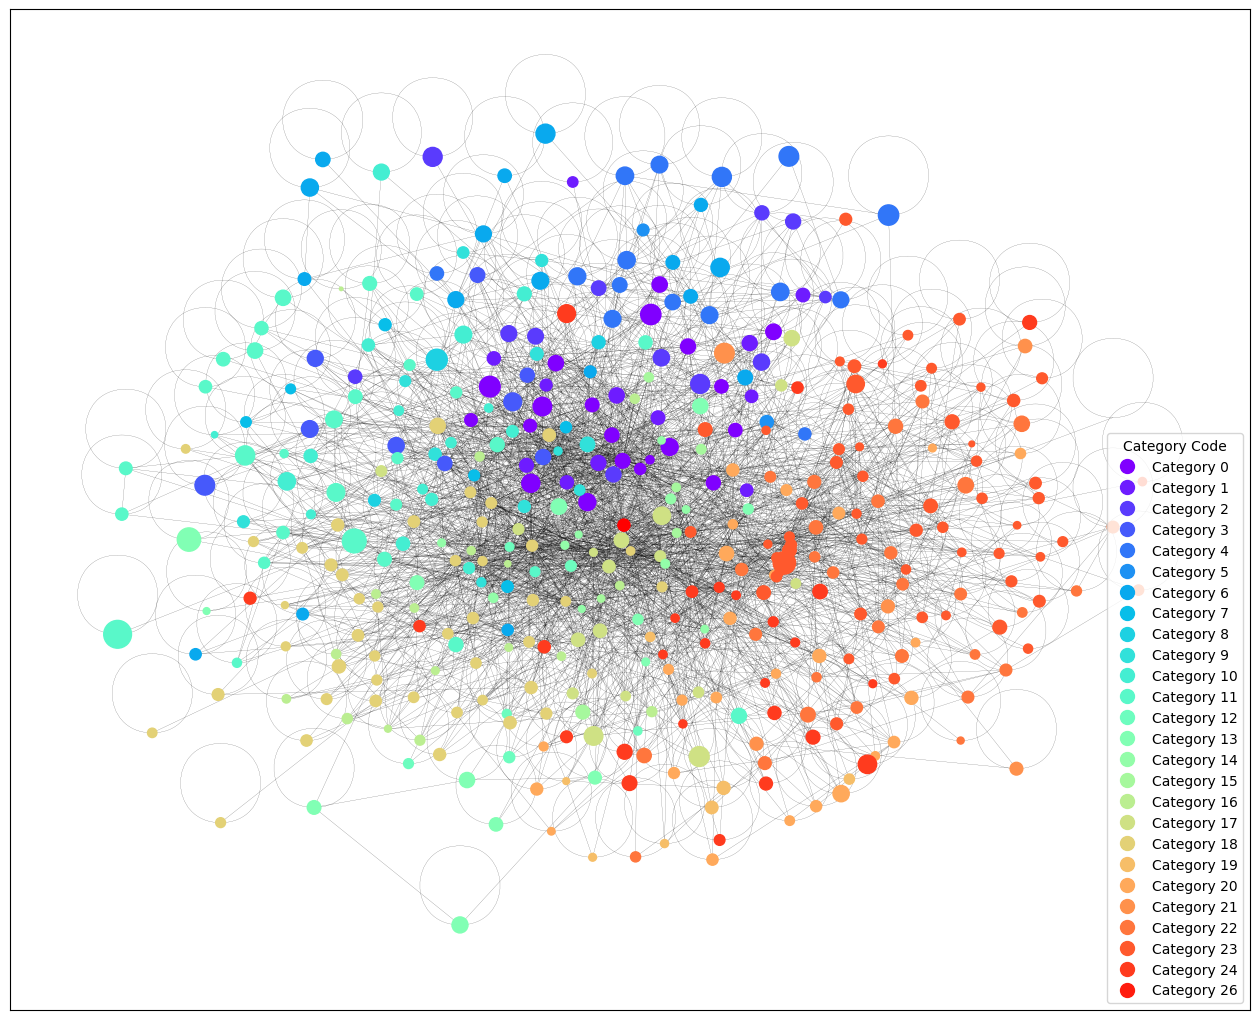

In [25]:
plt.figure(figsize=(16, 13))

ATTRIBUTE_NAME = 'category_code'
#COLOR_SCHEME = "tab20" # try plt.cm.Blues if your attribute is a continuous variable
colors = [G.nodes[node][ATTRIBUTE_NAME] for node in list(G.nodes)]

nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G, scale=2), 
                 node_size=[G.nodes[node]['Average_INCWAGE']*400 for node in list(G.nodes)], 
                 width=0.1,
                 node_color=colors, 
                 cmap='rainbow', 
                 with_labels=False)

category_codes = set(colors)
normalizer = matplotlib.colors.Normalize(0, len(category_codes))
legend_labels = {code: f'Category {code}' for code in category_codes}
handles = [plt.Line2D([], [], marker='o', linestyle='', color=plt.cm.rainbow(normalizer(i)), markersize=10, label=label) for i, label in enumerate(legend_labels.values())]
plt.legend(handles=handles, title='Category Code')

plt.show()

In [26]:
list(set(data_23['OCC2010']).symmetric_difference(set(data_23['OCC10LY'])))

[1440, 7730, 9999]

In [27]:
data_23[data_23['OCC2010'] == 6460]

,OCC2010,OCC10LY,Category,ASECWT,Average_INCWAGE,ASECWT_normalized,category_code
2742,6460,6460,CONSTRUCTION,12356.81,0.072435,0.002569,20
2743,6460,9600,CONSTRUCTION,1352.96,0.072435,0.000253,20


In [29]:
n = 10
average_wages_df[average_wages_df['OCC2010'] == n]['Average_INCWAGE'][0]

0.5544773837197945

## Create network using loop

In [30]:
## Create undirected network
G = nx.Graph()
for ind, row in data_23.iterrows():
    n1 = int(row["OCC2010"])
    n2 = int(row["OCC10LY"])
    category_code = int(row["category_code"])

    if not G.has_node(n1):
        if (average_wages_df['OCC2010'] == n1).any():
            avg_incwage = average_wages_df[average_wages_df['OCC2010'] == n1]['Average_INCWAGE'].values[0]
        else:
            avg_incwage = 0.0

        G.add_node(n1,category=category_code, avg_incwage=avg_incwage)

    if not G.has_node(n2):
        if (average_wages_df['OCC2010'] == n2).any():
            avg_incwage = average_wages_df[average_wages_df['OCC2010'] == n2]['Average_INCWAGE'].values[0]
        else:
            avg_incwage = 0.0
        G.add_node(n2,category=category_code, avg_incwage=avg_incwage)

    intr = row["ASECWT"]
    intr_inv = row["ASECWT_normalized"]
    if G.has_edge(n1,n2):
        G[n1][n2]["ASECWT"] += intr
        G[n1][n2]["ASECWT_normalized"] += intr_inv
    else:
        G.add_edge(n1,n2,ASECWT=intr, ASECWT_normalized = intr_inv)

In [31]:
G.nodes.data()

NodeDataView({10: {'category': 0, 'avg_incwage': 0.5544773837197945}, 20: {'category': 0, 'avg_incwage': 0.3697018793522233}, 30: {'category': 0, 'avg_incwage': 0.3672954106216245}, 120: {'category': 0, 'avg_incwage': 0.4245428398612534}, 410: {'category': 0, 'avg_incwage': 0.20318967339389873}, 710: {'category': 0, 'avg_incwage': 0.2983913184022166}, 910: {'category': 0, 'avg_incwage': 0.34223760339816683}, 2100: {'category': 0, 'avg_incwage': 0.5718547871498655}, 4340: {'category': 0, 'avg_incwage': 0.09579733400402414}, 4850: {'category': 0, 'avg_incwage': 0.27144417242370483}, 4940: {'category': 0, 'avg_incwage': 0.15977112676056338}, 5600: {'category': 0, 'avg_incwage': 0.29755679666232693}, 350: {'category': 0, 'avg_incwage': 0.26140336885360504}, 420: {'category': 0, 'avg_incwage': 0.2090732274079258}, 430: {'category': 0, 'avg_incwage': 0.27537211010289087}, 1010: {'category': 0, 'avg_incwage': 0.3397875939849624}, 1020: {'category': 0, 'avg_incwage': 0.4107607444668008}, 2200:

In [32]:
G.number_of_nodes()

422

(-2.253918402049998, 2.2875923582144275, -2.42112151371608, 2.5344014151289613)

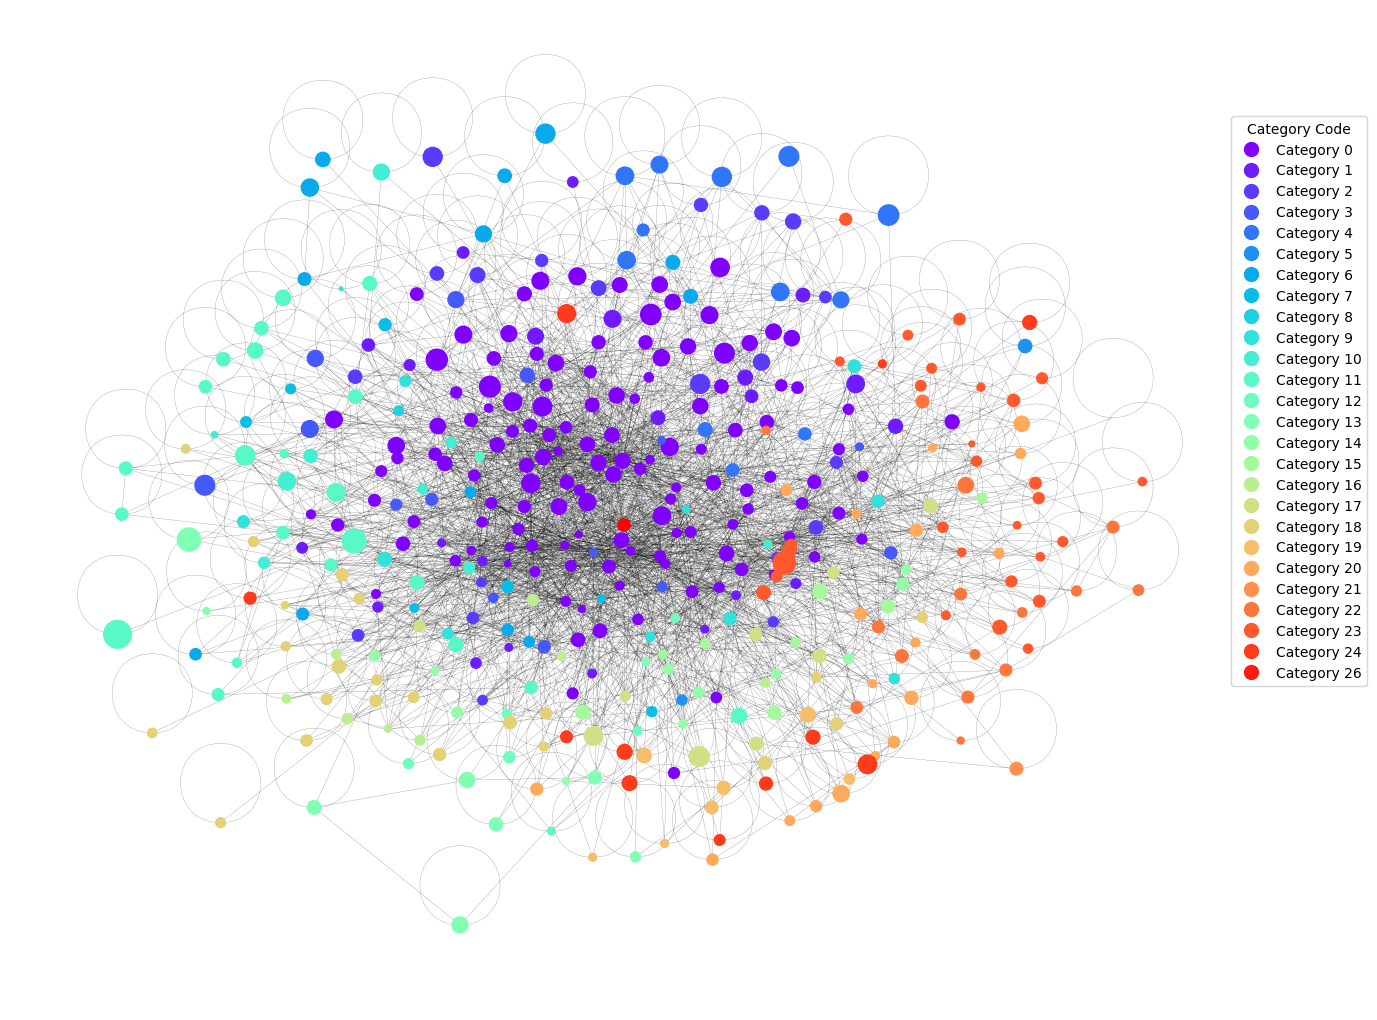

In [33]:
## Compute a layout
pos = nx.kamada_kawai_layout(G,
                            #weight="ASECWT",
                            scale=2)

## Fix a node ordering
nodelist = G.nodes
## Convert classes labels to numbers for plotting
colors = [G.nodes[ni]["category"] for ni in nodelist]
size = [G.nodes[node]['avg_incwage']*400 for node in list(G.nodes)]
plt.figure(figsize=(16, 13))
nx.draw_networkx(G,
                 pos=pos,
                 node_size=size,
                 font_size=7,
                 width=0.1, ## Edge width
                 #nodelist=nodelist, 
                 node_color=colors,
                 cmap="rainbow",
                 with_labels=False,
                 #labels={ni:G.nodes[ni]["category"] for ni in nodelist}, ## Label each node (student) with the class she attends
                 font_color="k"
                )

category_codes = set(colors)
normalizer = matplotlib.colors.Normalize(0, len(category_codes))
legend_labels = {code: f'Category {code}' for code in category_codes}
handles = [plt.Line2D([], [], marker='o', linestyle='', color=plt.cm.rainbow(normalizer(i)), markersize=10, label=label) for i, label in enumerate(legend_labels.values())]
plt.legend(handles=handles, title='Category Code', loc='upper right', bbox_to_anchor=(1.1, 0.9))
plt.axis("off")